In [1]:
# Import necessary libraries
import torch.cuda as torch_cuda
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.utils import make_grid

## Verify GPU

In [2]:
print('===VERIFY GPU===')
print('CUDA IS AVAILABLE:', torch_cuda.is_available())
print('DEVICE COUNT:', torch_cuda.device_count())
print('DEVICE NAME:', torch_cuda.get_device_name(0))

# If CUDA is available, print GPU details
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0)} bytes")

# Select device: GPU if available, otherwise CPU
device = torch.device('cuda:0' if torch_cuda.is_available() else 'cpu')


===VERIFY GPU===
CUDA IS AVAILABLE: True
DEVICE COUNT: 1
DEVICE NAME: NVIDIA RTX A4000
Number of GPUs: 1
GPU Name: NVIDIA RTX A4000
GPU Memory Allocated: 0 bytes
GPU Memory Cached: 0 bytes


## Dataset

In [3]:
# Define hyperparameters
batch_size = 16

# Take a subset of the dataset - we are only interested in two classes for now
classes = [0,1] 

# Define transformations: Convert to tensor and normalize
transformations = transforms.Compose([
    transforms.ToTensor()
])

mnist_trainset = datasets.MNIST(
    root='Dataset',
    train=True,
    download=True,
    transform=transformations
)

mnist_testset = datasets.MNIST(
    root='Dataset',
    train=False,
    download=True,
    transform=transformations
)

train_indices = [i for i, label in enumerate(mnist_trainset.targets) if label in classes]
test_indices = [i for i, label in enumerate(mnist_testset.targets) if label in classes]

# Take a subset of the dataset based on the indices we identified as belonging to the class
train_subset = Subset(mnist_trainset, train_indices)
test_subset = Subset(mnist_testset, test_indices)


In [4]:
trainloader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True
)

testloader = DataLoader(
    test_subset,
    batch_size=batch_size,
    shuffle=False
)

TRAIN SET LENGTH: 12665
TEST SET LENGTH: 2115


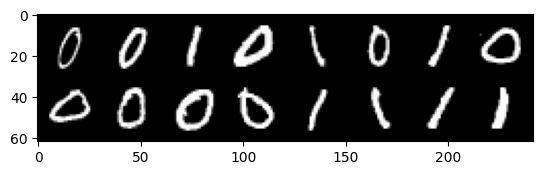

In [5]:
print('TRAIN SET LENGTH:', len(train_subset))
print('TEST SET LENGTH:', len(test_subset))

def imshow(img):

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), vmin=0, vmax=1)
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(make_grid(images))

## AutoEncoder

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, encoding_dim=60):
        super(AutoEncoder, self).__init__()
        # Encoding from 784 (32*32) to an arbitary number of features
        self.encoder = nn.Linear(784, encoding_dim)
        # Encoding to 784 (32*32) to an arbitary number of features
        self.decoder = nn.Linear(encoding_dim, 784)

    def forward(self, x):
        x = x.reshape(-1, 784)
        x = F.relu(self.encoder(x))
        x = self.decoder(x)
        return x

In [7]:
encoder_epochs = 20

encoder = AutoEncoder(64).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(encoder.parameters())

In [8]:
def train(epoch):
    train_loss = 0.0

    for data in trainloader:
        images, _ = data

        images = images.view(images.size(0), -1)
        images = images.to(device)

        optimizer.zero_grad()

        outputs = encoder(images)

        loss = criterion(outputs, images)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(trainloader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

# Run the training and testing for defined epochs
for epoch in range(encoder_epochs):
    train(epoch)

Epoch: 0 	Training Loss: 0.381036
Epoch: 1 	Training Loss: 0.193096
Epoch: 2 	Training Loss: 0.160972
Epoch: 3 	Training Loss: 0.148949
Epoch: 4 	Training Loss: 0.144249
Epoch: 5 	Training Loss: 0.141512
Epoch: 6 	Training Loss: 0.140888
Epoch: 7 	Training Loss: 0.140352
Epoch: 8 	Training Loss: 0.140057
Epoch: 9 	Training Loss: 0.140087
Epoch: 10 	Training Loss: 0.139257
Epoch: 11 	Training Loss: 0.139543
Epoch: 12 	Training Loss: 0.139112
Epoch: 13 	Training Loss: 0.139014
Epoch: 14 	Training Loss: 0.139193
Epoch: 15 	Training Loss: 0.138956
Epoch: 16 	Training Loss: 0.138817
Epoch: 17 	Training Loss: 0.138975
Epoch: 18 	Training Loss: 0.138682
Epoch: 19 	Training Loss: 0.138743


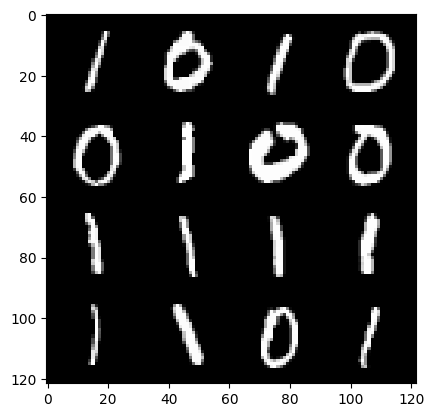

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.300357..1.3190101].


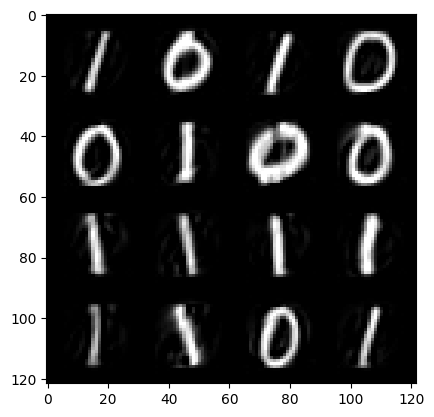

In [9]:
from torchvision.utils import make_grid


def imshow(img):
    npimg = img.numpy()
    #transpose: change array axis to correspond to the plt.imshow() function     
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

# load 16 images from testset
inputs, _ = next(iter(testloader))
inputs_example = make_grid(inputs[:16,:,:,:],4)
imshow(inputs_example)

#convert from image to tensor
inputs=inputs.cuda()
inputs=torch.reshape(inputs,(-1,784))

# get the outputs from the trained model
outputs=encoder(inputs)

#convert from tensor to image
outputs=torch.reshape(outputs,(-1,1,28,28))
outputs=outputs.detach().cpu()

#show the output images
outputs_example = make_grid(outputs[:16,:,:,:],4)
imshow(outputs_example)

In [10]:
def encode_dataset():
    encoder.eval()
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []

    with torch.no_grad():
      for data, label in trainloader:
          # Get the encoded features (latent space representation)
          encoded = encoder.encoder(data.view(-1, 28 * 28).to(device))
          train_features.append(encoded.to('cpu'))
          train_labels.append(label)

      for data, label in testloader:
          # Get the encoded features (latent space representation)
          encoded = encoder.encoder(data.view(-1, 28 * 28).to(device))
          test_features.append(encoded.to('cpu'))
          test_labels.append(label)

    return torch.cat(train_features, dim=0), torch.cat(test_features, dim=0), torch.cat(train_labels, dim=0), torch.cat(test_labels, dim=0)

features_to_train, features_to_test, labels_to_train, labels_to_test = encode_dataset()

In [11]:
train_dataset = torch.utils.data.TensorDataset(features_to_train, labels_to_train)
test_dataset = torch.utils.data.TensorDataset(features_to_test, labels_to_test)

In [12]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

## Model

In [13]:
momentum_coeff = 0.9
learning_rate = 0.01
learning_decay = 10**-9
epochs = 10

# Classes for MNIST digits
classes = (0,1)

In [14]:
# Define a multi-layer perceptron (MLP) model
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()

        # Define linear layers
        self.input_layer = nn.Linear(64, 100)
        self.hidden_layer1 = nn.Linear(100, 100)
        self.hidden_layer2 = nn.Linear(100, 100)
        self.hidden_layer3 = nn.Linear(100, 100)
        self.hidden_layer4 = nn.Linear(100, 100)
        self.out = nn.Linear(100, 1)

        # Define dropout layers
        self.dropout_layer1 = nn.Dropout(p=0.5)
        self.dropout_layer2 = nn.Dropout(p=0.5)
        self.dropout_layer3 = nn.Dropout(p=0.5)
        self.dropout_layer4 = nn.Dropout(p=0.5)

    def forward(self, x, output=5):

        # Pass through layers with ReLU activation and dropout
        x = F.relu(self.input_layer(x))

        x = F.relu(self.hidden_layer1(x))
        if output == 1:
            return x
        x = self.dropout_layer1(x)
        
        x = F.relu(self.hidden_layer2(x))
        if output == 2:
            return x
        x = self.dropout_layer2(x)
        
        x = F.relu(self.hidden_layer3(x))
        if output == 3:
            return x
        x = self.dropout_layer3(x)
        
        x = F.relu(self.hidden_layer4(x))
        if output == 4:
            return x
        x = self.dropout_layer4(x)
        
        # IMPORTANT FIX: Do not apply softmax here.
        # CrossEntropyLoss expects raw logits.
        x = self.out(x)
        return x  # Return raw logits

# Instantiate and move model to the selected device
mlp = MLP().to(device)

loss_function = nn.BCELoss()  # CrossEntropyLoss expects raw logits
optimizer = optim.SGD(mlp.parameters(), lr=learning_rate,
                      momentum=momentum_coeff, weight_decay=learning_decay)


In [16]:
def train(epoch):
    mlp.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.unsqueeze(1).to(device, dtype=torch.float32)
        optimizer.zero_grad()
        output = mlp(data)
        print(output.dtype)
        print(target.dtype)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {:>3}\t[{:>5}/{:>5} ({:>3.0f}%)]\tLoss: {:>7.6f}'.format(
                    epoch + 1, batch_idx * len(data), len(trainloader.dataset),
                    100. * batch_idx / len(trainloader), loss.item()))

def test():
    mlp.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            # Move data and targets to device
            data, target = data.to(device), target.to(device)
            # Forward pass
            output = mlp(data)
            # Compute loss and accumulate
            test_loss += loss_function(output, target).item()
            # Get predicted classes
            pred = output.argmax(dim=1, keepdim=True)
            # Count how many predictions are correct
            correct += pred.eq(target.view_as(pred)).sum().item()
    # Average loss over the entire test set
    test_loss /= len(testloader)
    # Print test performance
    print('\nTest set: Average loss: {:>10.4f}, Accuracy: {:>5}/{:>5} ({:>3.3f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


# Run the training and testing for defined epochs
for epoch in range(epochs):
    train(epoch)
    test()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## SHAP

In [163]:
images = []
labels = []

for batch_idx, (image_batch, label_batch) in enumerate(trainloader):
    for i in range(0, batch_size):
        images.append(image_batch[i])
    if len(images) >= 110:
        break

background_images = np.array(images[:100])
test = np.array(images[100:])
background = torch.from_numpy(background_images)

test_out = mlp(background.to(device))
test_out

tensor([[-12.2305,  11.1956],
        [-10.7242,   9.8309],
        [ 20.1119, -24.7768],
        [-13.0677,  11.9548],
        [-10.0761,   9.2430],
        [-12.2911,  11.2499],
        [ 10.8338, -13.4344],
        [-12.6277,  11.5564],
        [ 10.7490, -13.3457],
        [-11.7571,  10.7674],
        [ 14.3246, -17.7225],
        [ -2.8571,   2.6961],
        [-10.9086,   9.9981],
        [-11.3720,  10.4177],
        [ 17.3708, -21.4109],
        [ 10.1685, -12.6183],
        [-12.1873,  11.1571],
        [ 19.2096, -23.6620],
        [ 11.9239, -14.7759],
        [ -9.4967,   8.7178],
        [ 14.2002, -17.5383],
        [ 25.4999, -31.3607],
        [ 12.1463, -15.0710],
        [-10.3669,   9.5059],
        [ 16.2319, -20.0194],
        [-12.4442,  11.3898],
        [ 13.3119, -16.4530],
        [-10.7939,   9.8936],
        [-11.2789,  10.3331],
        [-12.8387,  11.7474],
        [  7.5976,  -9.5125],
        [-10.6511,   9.7633],
        [ 13.3710, -16.5156],
        [ 

In [ ]:
import shap

e = shap.DeepExplainer(mlp, background.to(device))
test_shap = e.shap_values(torch.from_numpy(test).to(device))

## Dimensionality Reduction

In [ ]:
def get_activations(layer = 4):
    activations = []
    labels = []
    predictions = []
    with torch.no_grad():

        #  Train Data Activations
        for data, target in trainloader:
            # Move data and targets to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = mlp(data, output=layer)
            for t in output:
                activations.append(t.to('cpu').numpy())
            target_arr = target.to('cpu').numpy()
            if len(target_arr) != batch_size:
                target_arr = np.pad(target_arr, (0, batch_size - len(target_arr)), mode='constant', constant_values=-1)
            labels.append(target_arr)

            output = mlp(data, output=5)
            for t in output:
                pred = np.argmax(t.to('cpu').numpy())
                predictions.append(pred)

        #  Test Data Activations
        for data, target in testloader:
            # Move data and targets to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = mlp(data, output=layer)
            for t in output:
                activations.append(t.to('cpu').numpy())
            target_arr = target.to('cpu').numpy()
            if len(target_arr) != batch_size:
                target_arr = np.pad(target_arr, (0, batch_size - len(target_arr)), mode='constant', constant_values=-1)
            labels.append(target_arr)

            output = mlp(data, output=5)
            for t in output:
                pred = np.argmax(t.to('cpu').numpy())
                predictions.append(pred)

    return activations, labels, predictions

activations, labels, predictions = get_activations(4)

[ 0  1  0  0  1  1  1  1  0 -1 -1 -1 -1 -1 -1 -1]
[ 1  0  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [ ]:
flat_labels = np.array(labels).flatten()
cleaned_labels = [i for i in flat_labels if i != -1]

In [ ]:
activations = np.array(activations)

predictions_df = pd.DataFrame(predictions, columns=['prediction'])
labels_df = pd.DataFrame(np.array(cleaned_labels).flatten(), columns=['class'])

,class
0,0
1,1
2,0
3,1
4,0


In [ ]:
from sklearn.manifold import TSNE

dim_red = TSNE(n_components = 2, random_state=0)
points = dim_red.fit_transform(activations)
points

array([[ 47.254368,  27.1345  ],
       [-28.813904, -22.195187],
       [ 67.71189 , -44.11951 ],
       ...,
       [-76.20368 ,  -6.519619],
       [ 61.03111 , -10.029565],
       [-91.674515,  -6.153782]], dtype=float32)

### Quick Plot

<Axes: xlabel='x', ylabel='y'>

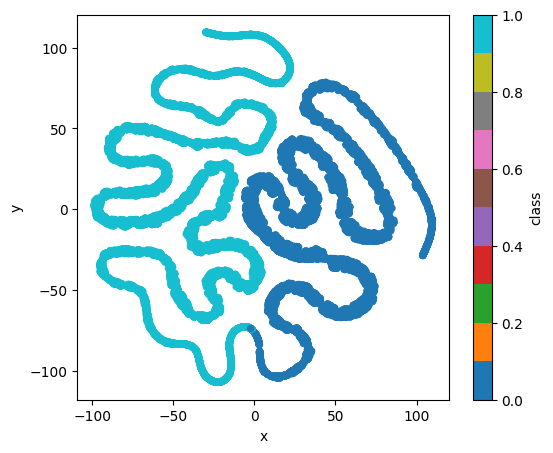

In [82]:
# Quick plot to check data
points_df = pd.DataFrame(points, columns=['x','y']).join(labels_df).join(predictions_df)

plt.rcParams["figure.figsize"] = [6, 5]
points_df.plot.scatter(
    x='x',
    y='y',
    c='class',
    colormap='tab10'
)